In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import MeCab
import re
import mojimoji
from janome.tokenizer import Tokenizer
import japanize_matplotlib
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Load the CSV file
df = pd.read_csv('period_1.csv', encoding='utf-8')
df.head()

,口コミ,投稿日
0,年末の家族旅行でお世話になりました。どうも有難うございました。一番のおすすめは、湯の里おかだ...,2019-12-30
1,箱根の温泉を楽しめました！色々な種類がありとても楽しめました他の温泉街も近いので楽しめると思います,2019-12-28
2,星空が満喫できる露天風呂で温泉三昧プランで予約しました。お風呂が、箱根の森にして本当に満足で...,2019-12-23
3,彼氏の誕生日の旅行で利用しました。2人部屋なのでそこまで広くはなかったですが、特に狭さは感じ...,2019-12-23
4,宿の中に色々なお店があって回っているだけで飽きずにそれだけでも楽しめました。誕生日旅行での予...,2019-12-22


In [33]:
# CSVファイルからデータフレームを読み込む
df = pd.read_csv('period_1.csv')

# MECABのインスタンスを生成
m = MeCab.Tagger("-Ochasen")

# 形態素解析を行い、結果を返す関数
def preprocess_text(text):
    # 全角を半角に変換
    text = mojimoji.zen_to_han(text, kana=False)
    
    # 数字を全て0に変換
    text = re.sub(r'[0-9]+', '0', text)
    
    # 形態素解析
    tokens = m.parse(text).split("\n")
    words = []
    for token in tokens[:-2]:  # EOSと空白を除く
        parts = token.split("\t")
        if parts[3].startswith(include_pos) and parts[0] not in stopwords:
            words.append(parts[0])
    
    return " ".join(words)

include_pos = ('名詞') # Considering only nouns for simplicity

# 既存のストップワード
stopwords = ('温泉','露天風呂','wi','fi','なに','以下','おすすめ','コス','みたい','今回','利用','部屋','風呂','料理',
'旅行','スタッフ','対応','お世話','しまう','くれる','ゆっくり','この','ちょっと','てる','良い','ただ','少し','思う','まで'
,'さん','せる','です','ます','から','なる','れる','こと','たい','ので','とても','もらう','もらえる','できる','また','ツル'
,'する', 'ある', 'ない', 'いう', 'もの', 'ところ', 'よう', 'これ', 'ため', 'それ', 'とき', 'それぞれ', 'これら', 'よる'
,'くる','1','2','3','一','さ','い','の','し','いる','よかっ','き','おか','なり','くれ','ん','そう','品数','何','二','肉'
,'どれ','こちら','中','ふき','おしり','しゃぶしゃぶ','ヶ所','フレンチ','パン','ビュッフェ','一つ','とこ','ここ','つき',
'小分け','ケーキ','わけ','トング','0','!','方','時')


# 指定されたカラムのテキストに前処理を適用
df["preprocessed_text"] = df["口コミ"].apply(preprocess_text)


# 新しいカラムを含むデータフレームをCSVファイルに保存
df.to_csv('period_1_preprocessed.csv', index=False)

# 結果を確認
df.head()

,口コミ,投稿日,preprocessed_text
0,年末の家族旅行でお世話になりました。どうも有難うございました。一番のおすすめは、湯の里おかだ...,2019-12-30,年末 家族 一番 湯の里 ホテル ふたつ 施設 点 どちら 屋外 必要 庇 下 スリッパ 移...
1,箱根の温泉を楽しめました！色々な種類がありとても楽しめました他の温泉街も近いので楽しめると思います,2019-12-28,箱根 色々 種類 他 街
2,星空が満喫できる露天風呂で温泉三昧プランで予約しました。お風呂が、箱根の森にして本当に満足で...,2019-12-23,星空 満喫 三昧 プラン 予約 箱根 森 満足 堪能 趣 夕焼け 展望 石 床 気 本館
3,彼氏の誕生日の旅行で利用しました。2人部屋なのでそこまで広くはなかったですが、特に狭さは感じ...,2019-12-23,彼氏 誕生 日 人 そこ テレビ 画質 事前 誕生 日 予約 こっち 好き 時間 メール 当...
4,宿の中に色々なお店があって回っているだけで飽きずにそれだけでも楽しめました。誕生日旅行での予...,2019-12-22,宿 色々 店 誕生 日 予約 相手 箱根 際


In [34]:
# 単語の頻出回数をカウントする
words_count = Counter()

# DataFrameの各行に対して単語をカウント
for text in df["preprocessed_text"]:
    words_count.update(text.split())

# ストップワードの除外
for sw in stopwords:
    if sw in words_count:
        del words_count[sw]

# 頻出単語とその回数をランキング形式で取得
word_ranking = words_count.most_common()

# トップ10の単語とその回数を出力
for word, freq in word_ranking[:10]:
    print(f"{word}: {freq}回")

食事: 385回
ホテル: 345回
満足: 326回
人: 305回
夕食: 293回
宿: 246回
バイキング: 235回
朝食: 224回
箱根: 219回
時間: 201回


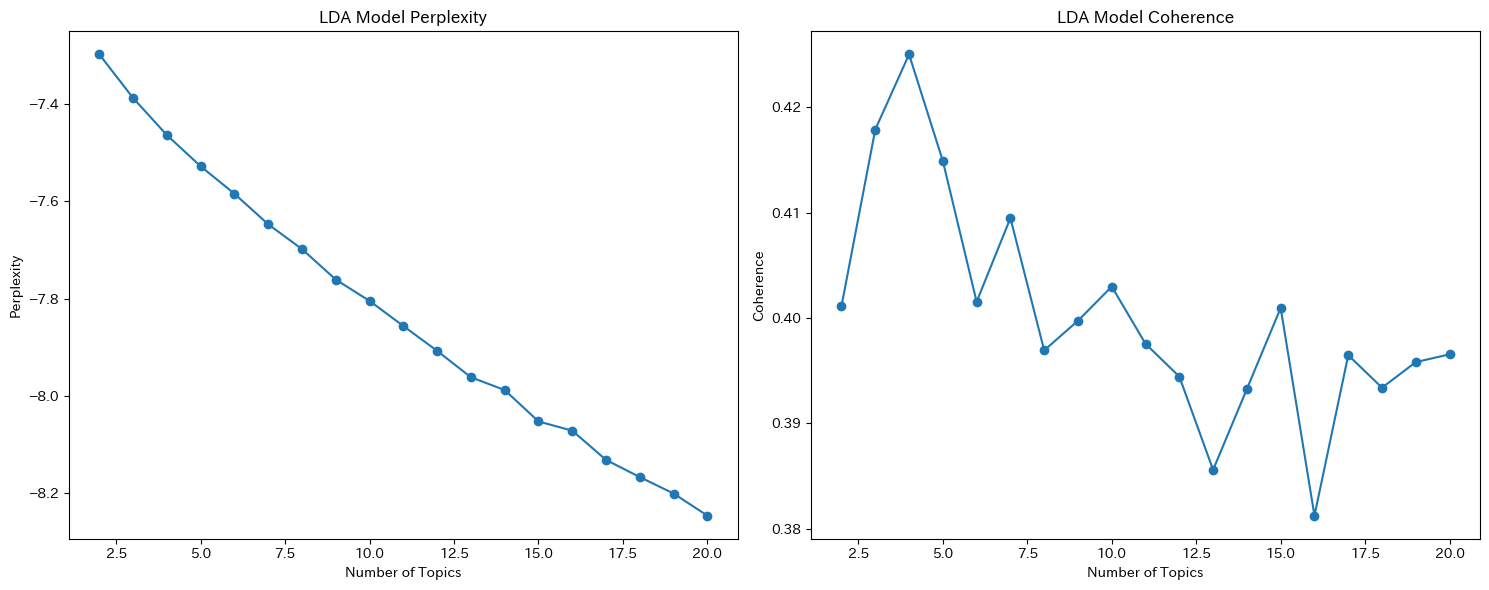

In [14]:
import numpy as np
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# あらかじめ分かち書き済みのテキストを用意
texts = df["preprocessed_text"].str.split()

# Gensimの辞書を作成
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# PerplexityとCoherenceの評価値を格納するリスト
perplexity_values = []
coherence_values = []

# 考慮するトピック数の範囲
topic_range = range(2, 21)  # 例: 2〜20のトピック数を試す

for num_topics in topic_range:
    # LDAの学習
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=0)

    # Perplexity
    perplexity_values.append(lda.log_perplexity(corpus))

    # Coherence
    coherence_model = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

# 評価指標のプロット
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Perplexity
plt.subplot(1, 2, 1)
plt.plot(topic_range, perplexity_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("LDA Model Perplexity")

# Coherence
plt.subplot(1, 2, 2)
plt.plot(topic_range, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.title("LDA Model Coherence")

plt.tight_layout()
plt.show()

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# ファイルパスのリスト（各期間に対応するファイル）
file_paths = ['period_1_preprocessed.csv']

# トピックごとのキーワードを取得する関数
def get_top_words(model, feature_names, n_top_words):
    topics_keywords = []
    for topic_idx, topic in enumerate(model.components_):
        topics_keywords.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return topics_keywords

# 各ファイルに対してトピック分析を行う
for file_path in file_paths:
    # データフレームを読み込む
    df = pd.read_csv(file_path)
    # TF-IDFによるベクトル化
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
    tfidf = tfidf_vectorizer.fit_transform(df["preprocessed_text"])

    # LDAの設定と学習
    n_topics = 10  # トピック数は適宜調整してください
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', random_state=0)
    lda.fit(tfidf)

    n_top_words = 13  # トピックごとに表示するキーワード数
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    topics_keywords_list = get_top_words(lda, tfidf_feature_names, n_top_words)

    # トピックとキーワードをDataFrameで表示
    df_topics = pd.DataFrame(topics_keywords_list, index=[f"Topic {i+1}" for i in range(n_topics)])
    print(f"\nTop words in topics for {file_path}:")
    
    display(df_topics)


Top words in topics for period_1_preprocessed.csv:


,0,1,2,3,4,5,6,7,8,9,10,11,12
Topic 1,クーラー,久々,全部,意味,悪臭,騒音,静か,キレイ,値段,富士山,バイキング,平日,写真
Topic 2,プール,海外,土産,時期,夕食,ホテル,星空,満喫,喫煙,箱根,三昧,結婚式,満足
Topic 3,ブッフェスタイル,雰囲気,卓球,電波,状況,wi,fi,シャンプー,食事,種類,シャワー,参考,様子
Topic 4,初日,gw,最高,夕食,箱根,十分,チェック,丁寧,口コミ,禁煙,食材,好き,ほう
Topic 5,一部,渋滞,男女,入れ替え,周辺,オススメ,富士山,残念,バルコニー,夕食,良心,母親,高齢
Topic 6,食事,満足,ホテル,夕食,バイキング,朝食,箱根,時間,宿泊,残念,綺麗,子供,最高
Topic 7,騒音,配置,恋人,ストレス,不満,マッサージ,家族,夕食,朝食,バイキング,子供,ご飯,電話
Topic 8,たっぷり,富士山,情報,ボード,立地,入り口,ランク,マタニティ,雰囲気,アップ,ボリューム,残念,満足
Topic 9,替え,クリスマス,おかげ,スタイル,ネタ,質問,寿司,吉野,パークス,一生懸命,夕食,箱根,清潔
Topic 10,離れ,つながり,渡り廊下,暖房,プール,両方,ふるさと,予想,使用,足湯,満足,以上,ご飯


In [31]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# まずはデータをロードし、前処理されたテキストを取得します
df = pd.read_csv('period_1_preprocessed.csv')

# トピックモデルのためのコーパスと辞書を作成
texts = [document.split() for document in df['preprocessed_text']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# LDAモデルの学習
n_topics = 10
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, random_state=0, update_every=1, passes=10, alpha='auto', per_word_topics=True)

# pyLDAvisを用いた可視化
vis_data = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(vis_data)

c:\Users\81808\anaconda3\envs\cacaobucks\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


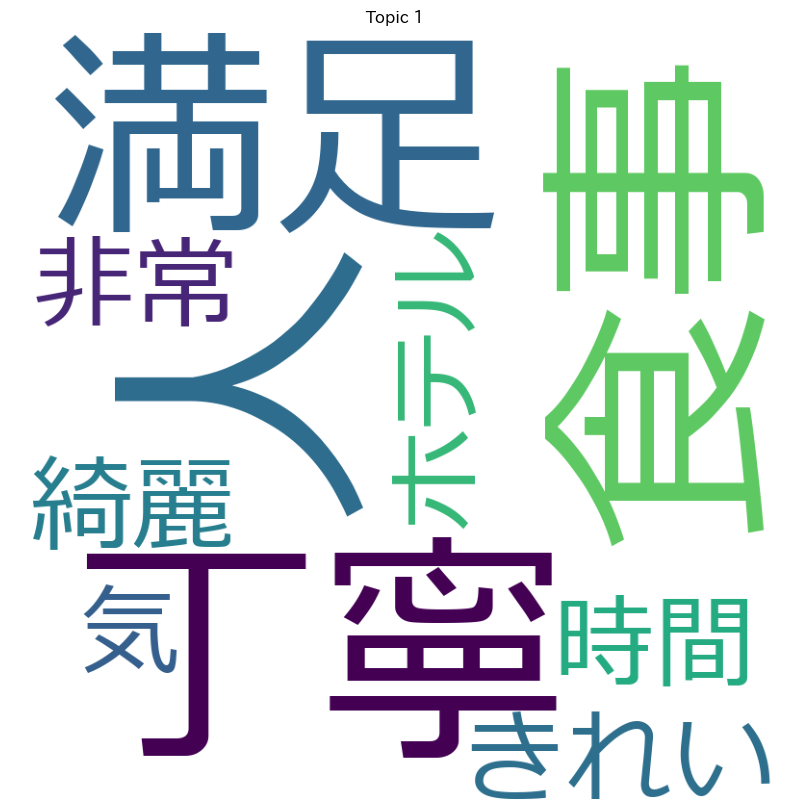

c:\Users\81808\anaconda3\envs\cacaobucks\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


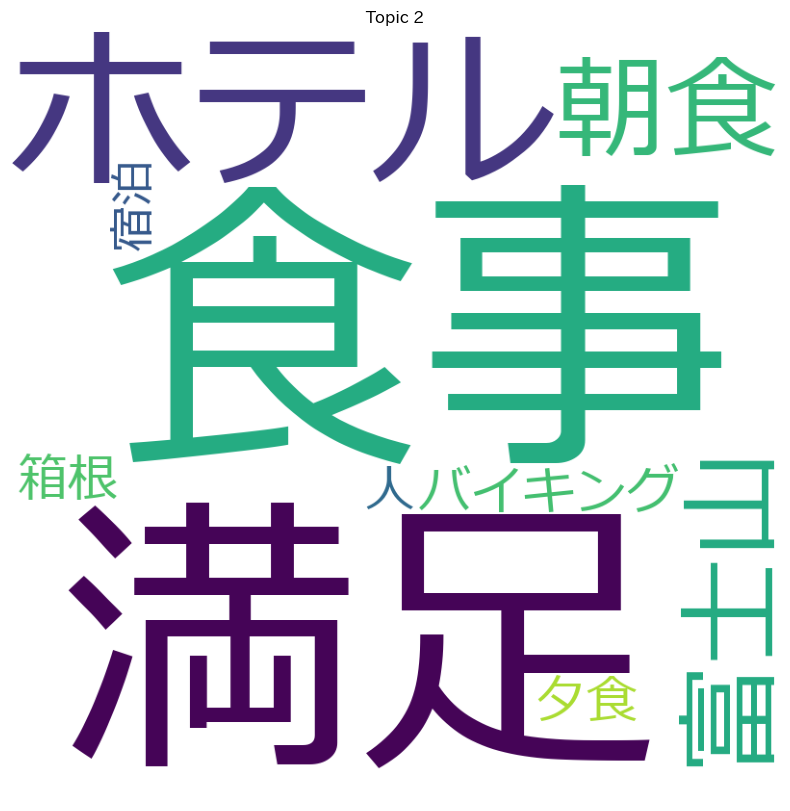

c:\Users\81808\anaconda3\envs\cacaobucks\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


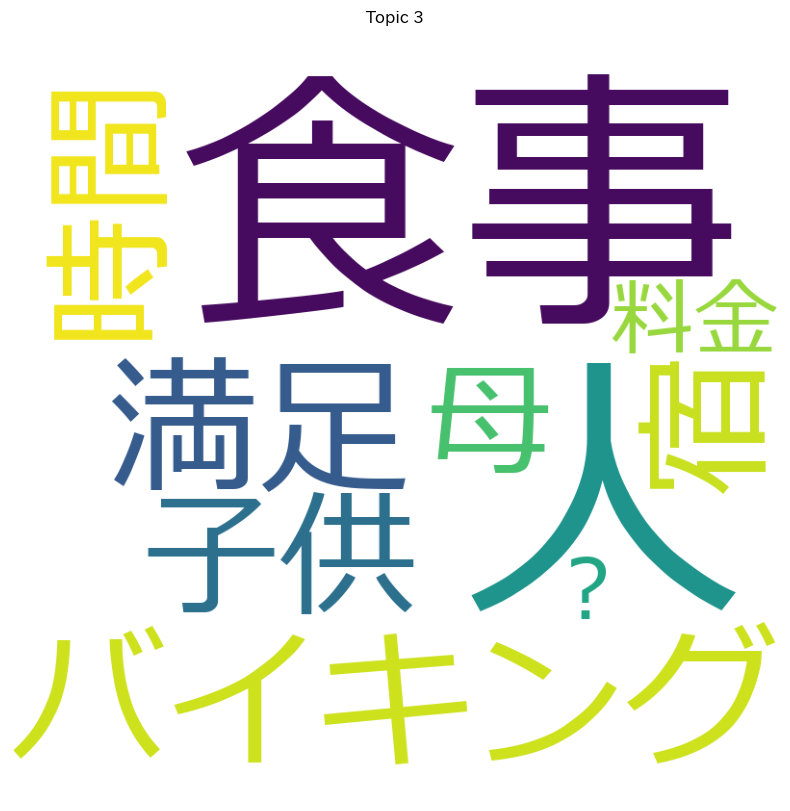

c:\Users\81808\anaconda3\envs\cacaobucks\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


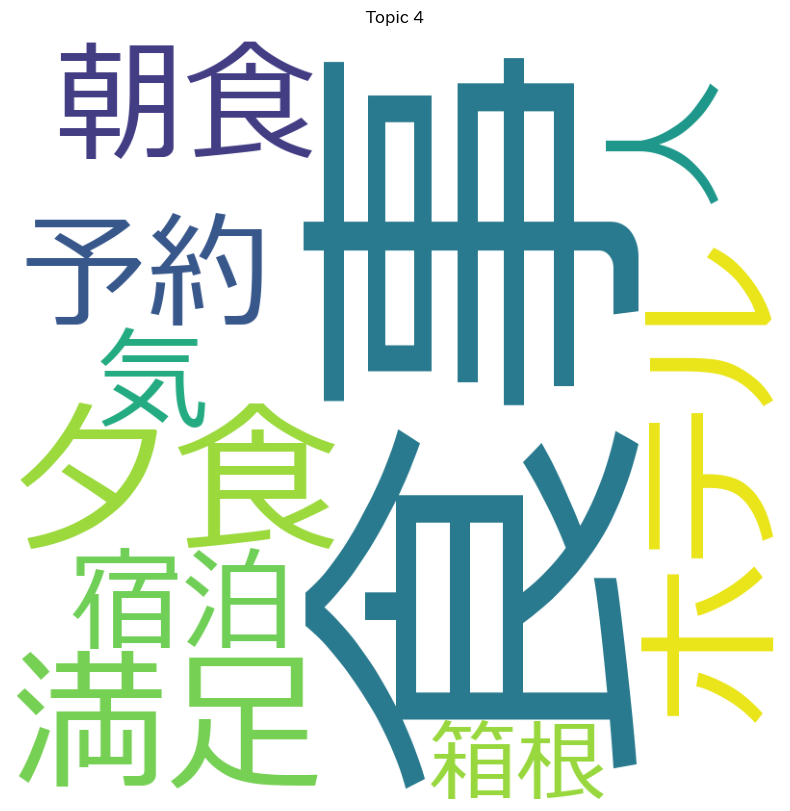

c:\Users\81808\anaconda3\envs\cacaobucks\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


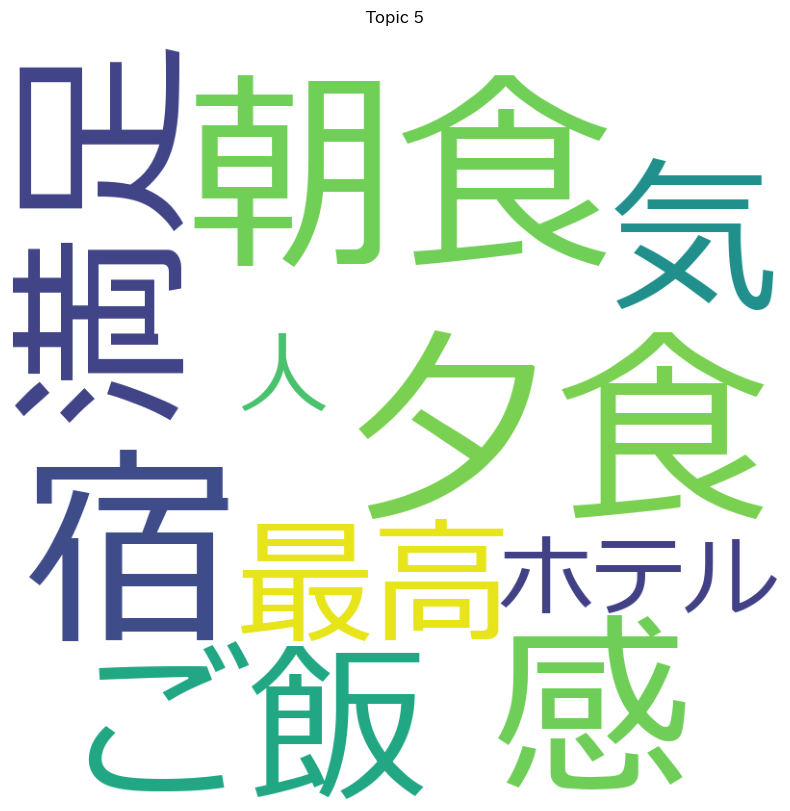

c:\Users\81808\anaconda3\envs\cacaobucks\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


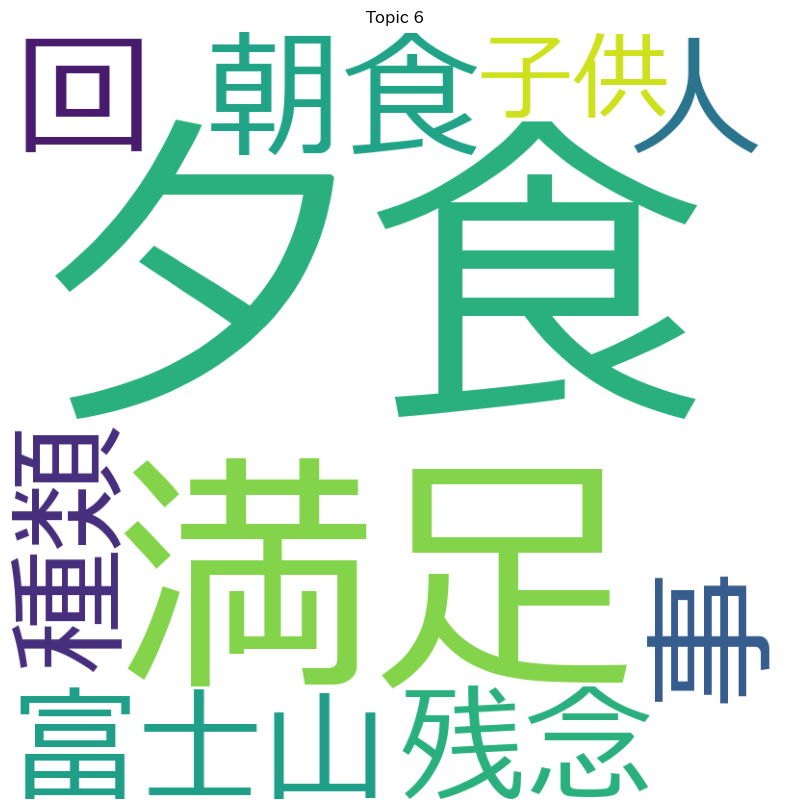

c:\Users\81808\anaconda3\envs\cacaobucks\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


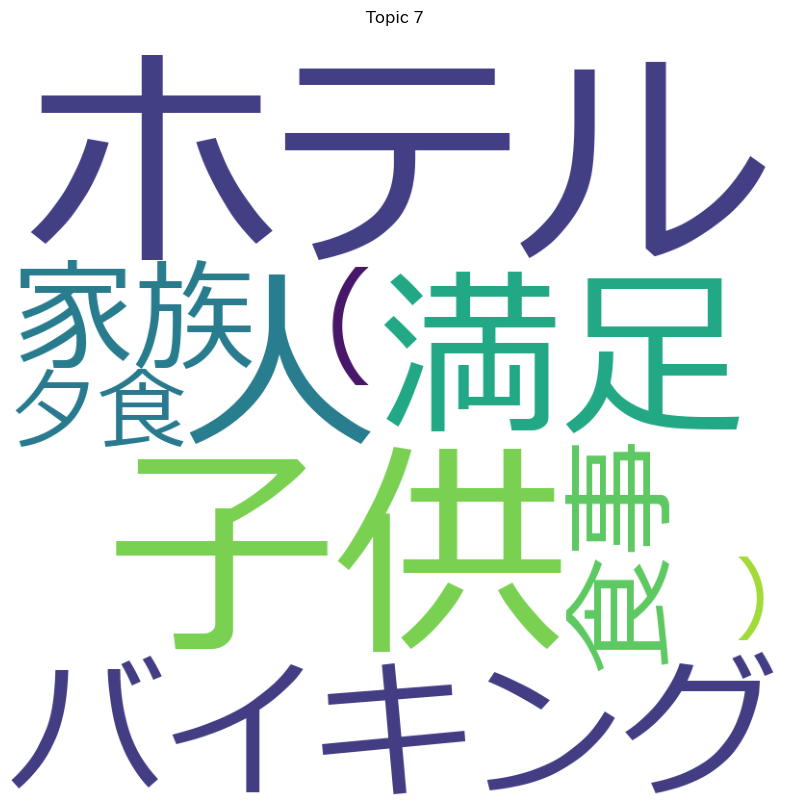

c:\Users\81808\anaconda3\envs\cacaobucks\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


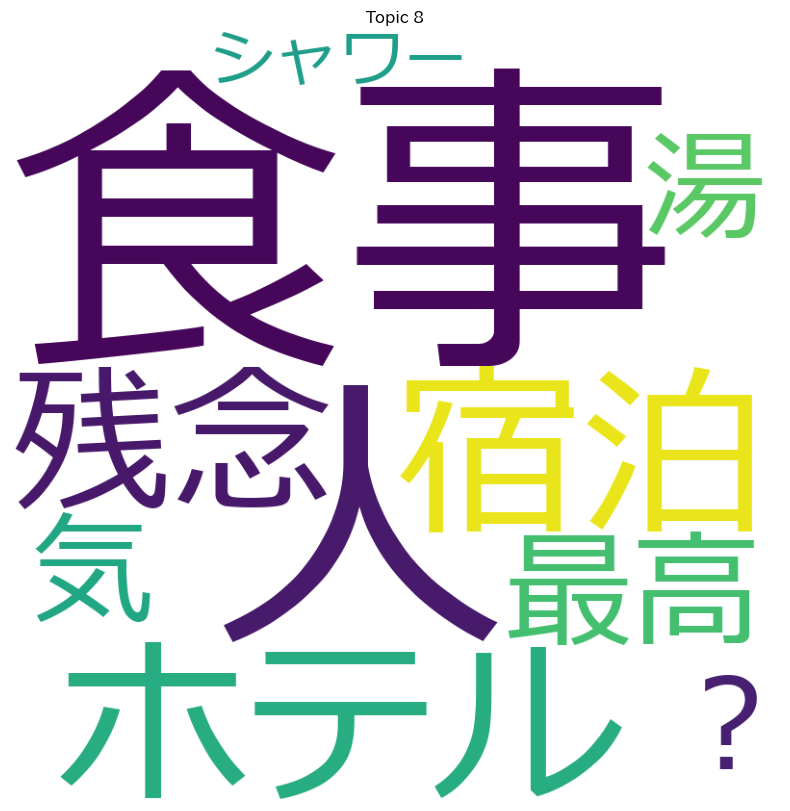

c:\Users\81808\anaconda3\envs\cacaobucks\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


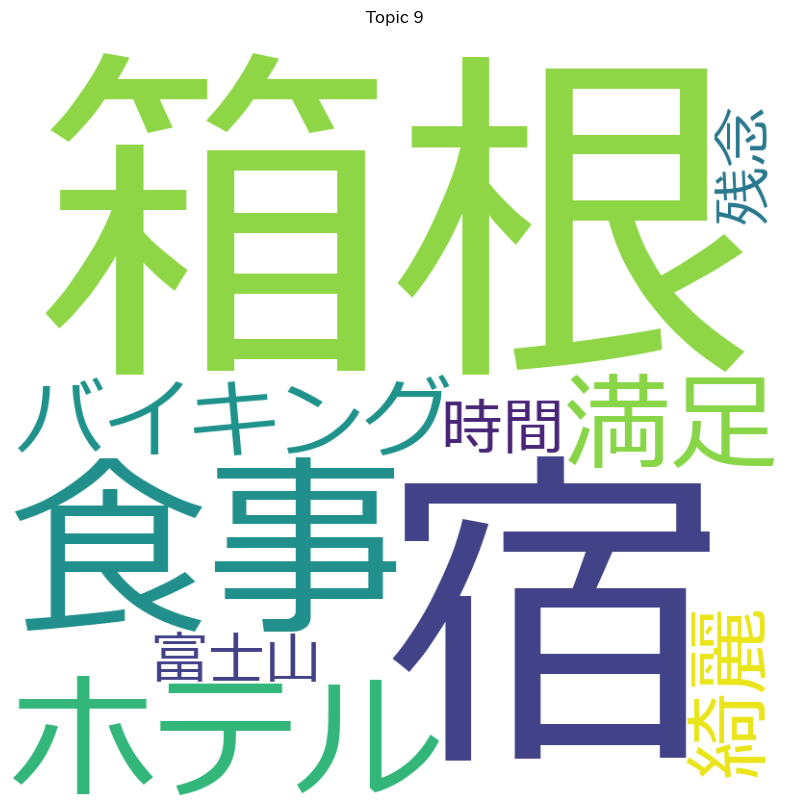

c:\Users\81808\anaconda3\envs\cacaobucks\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


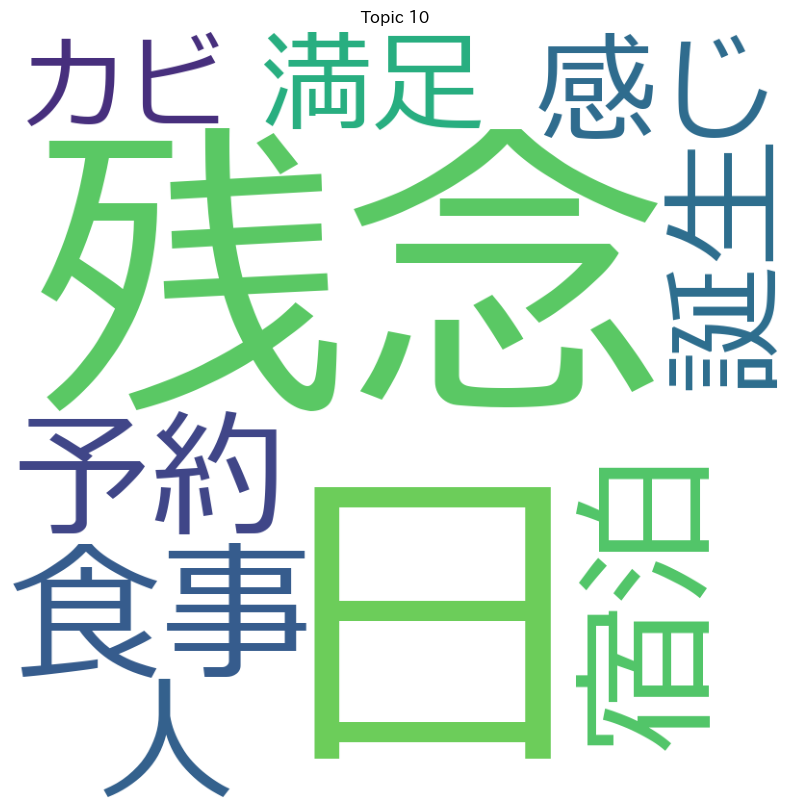

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# LDAモデルと辞書を用いてトピックごとのキーワードを取得
topics = lda_model.show_topics(num_topics=n_topics, num_words=10, formatted=False)

# 日本語フォントのパスを指定（環境に合わせて適宜変更してください）
font_path = 'C:\\Windows\\Fonts\\meiryo.ttc'

# 各トピックのキーワードを基にワードクラウドを生成
for t in range(len(topics)):
    plt.figure(figsize=(10, 10))

    # トピックからキーワードと重みを取得
    topic_words = dict(topics[t][1])

    # WordCloudオブジェクトを生成
    wordcloud = WordCloud(
        font_path=font_path,
        background_color='white',
        width=800,
        height=800,
        max_words=50
    ).generate_from_frequencies(topic_words)

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Topic {t+1}")
    plt.show()